In [1]:
import yfinance as yf
import pandas as pd
import alpaca_trade_api as tradeapi
from alpaca_trade_api import TimeFrame
import numpy as np
import warnings
import matplotlib.pyplot as plt
import schedule
import time
import logging

In [2]:
API_KEY = 'PKRDCTFNACLKDG4WP7PB'
API_SECRET = '6tDSFjckn5eOwF9wftJylb6LWjkrKAeh7ZWGeqhj'
BASE_URL = 'https://paper-api.alpaca.markets'
warnings.filterwarnings("ignore")

In [3]:
api = tradeapi.REST(API_KEY, API_SECRET, BASE_URL, api_version='v2')
account = api.get_account()
print(account)

Account({   'account_blocked': False,
    'account_number': 'PA3JXD33ELD2',
    'accrued_fees': '0',
    'admin_configurations': {},
    'balance_asof': '2024-11-01',
    'bod_dtbp': '0',
    'buying_power': '199977.17',
    'cash': '100000',
    'created_at': '2024-11-02T22:52:49.555301Z',
    'crypto_status': 'ACTIVE',
    'crypto_tier': 0,
    'currency': 'USD',
    'daytrade_count': 0,
    'daytrading_buying_power': '0',
    'effective_buying_power': '199977.17',
    'equity': '100000',
    'id': 'a46fa60f-dcdf-48d9-a84d-1c0d37b3261c',
    'initial_margin': '11.42',
    'intraday_adjustments': '0',
    'last_equity': '100000',
    'last_maintenance_margin': '0',
    'long_market_value': '0',
    'maintenance_margin': '0',
    'multiplier': '2',
    'non_marginable_buying_power': '99977.17',
    'options_approved_level': 2,
    'options_buying_power': '99988.58',
    'options_trading_level': 2,
    'pattern_day_trader': False,
    'pending_reg_taf_fees': '0',
    'portfolio_value': 

In [4]:
start = '2024-01-01'
end = '2024-01-02'
bars = api.get_bars('TSLA', TimeFrame.Minute, start = start, end = end).df
print(bars)

                              close    high     low  trade_count    open  \
timestamp                                                                  
2024-01-02 09:00:00+00:00  250.8800  250.88  248.05          490  248.05   
2024-01-02 09:01:00+00:00  250.6400  250.80  250.49          267  250.80   
2024-01-02 09:02:00+00:00  250.7400  250.74  250.55          239  250.63   
2024-01-02 09:03:00+00:00  250.8700  250.88  250.74          151  250.74   
2024-01-02 09:04:00+00:00  250.7500  250.75  250.71           83  250.71   
...                             ...     ...     ...          ...     ...   
2024-01-03 00:55:00+00:00  247.8901  247.98  247.88           60  247.93   
2024-01-03 00:56:00+00:00  247.9300  247.95  247.90           59  247.90   
2024-01-03 00:57:00+00:00  248.0900  248.16  247.90          119  247.93   
2024-01-03 00:58:00+00:00  248.0000  248.04  247.93           67  248.01   
2024-01-03 00:59:00+00:00  248.0000  248.04  247.96          105  248.00   

           

In [5]:
# ----------- Simple Moving Averages (SMA) Crossover Strategy ----------- #

# Create 50-day (short-term) and 200-day (long-term) moving averages
# Buy signal - when short-term average crosses above long-term average
# Sell signal - when short-term average crosses below long-term average

def sma_crossover_strategy(ticker, start, end):
    # Fetch historical data
    data = yf.download(ticker, start=start, end=end)
    # 50-day and 200-day moving averages
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data ['Close'].rolling(window=200).mean()
    # Buy/Sell signals
    data['Signal'] = 0
    data['Signal'][50:] = np.where(data['SMA_50'][50:] > data['SMA_200'][50:], 1, 0)
    data['Position'] = data['Signal'].diff()
    return data

sma_strategy_tsla = sma_crossover_strategy('TSLA', '2020-01-01', '2021-01-01')
print(sma_strategy_tsla[['Close', 'SMA_50', 'SMA_200', 'Signal', 'Position']].iloc[250:270])


[*********************100%%**********************]  1 of 1 completed

                 Close      SMA_50     SMA_200  Signal  Position
Date                                                            
2020-12-29  221.996674  174.249933  108.828086       1       0.0
2020-12-30  231.593338  176.009599  109.842653       1       0.0
2020-12-31  235.223328  177.901133  110.898363       1       0.0


In [6]:
# ----------- Relative Strength Index Strategy ----------- #

# Calculate RSI - momentum oscillator ranging 0-100
# Buy signal - RSI > 60  (stock is strong)
# Sell signal - RSI < 40 (stock is weak)

def compute_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain/loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def rsi_strategy(ticker, start, end):
    # Fetch historical data
    data = yf.download(ticker, start=start, end=end)
    # Compute RSI and create buy/sell signals
    data['RSI'] = compute_rsi(data)
    data['Signal'] = 0
    data['Signal'][data['RSI'] < 40] = -1
    data['Signal'][data['RSI'] > 60] = 1
    data['Position'] = data['Signal'].diff()
    return data

rsi_strategy_tsla = rsi_strategy('TSLA', '2020-01-01', '2021-01-01')
print(rsi_strategy_tsla[['Close', 'RSI', 'Signal', 'Position']].tail())

[*********************100%%**********************]  1 of 1 completed

                 Close        RSI  Signal  Position
Date                                               
2020-12-24  220.589996  59.472111       0       0.0
2020-12-28  221.229996  53.776735       0       0.0
2020-12-29  221.996674  52.831188       0       0.0
2020-12-30  231.593338  66.853303       1       1.0
2020-12-31  235.223328  65.339575       1       0.0


In [29]:
# ----------- Mean-Reversion Strategy ----------- #

def mean_reversion_strategy(ticker, start, end):
    # Fetch historical data
    data = yf.download(ticker, start=start, end=end)
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['Std_Dev'] = data['Close'].rolling(window=20).std()
    data['Upper_Band'] = data['SMA_20'] + (2 * data['Std_Dev'])
    data['Lower_Band'] = data['SMA_20'] - (2 * data['Std_Dev'])
    # Buy/sell signals
    data['Signal'] = 0
    data['Signal'] = np.where(data['Close'] < data['Lower_Band'], 1, data['Signal'])
    data['Signal'] = np.where(data['Close'] > data['Upper_Band'], -1, data['Signal'])
    data['Position'] = data['Signal'].diff()
    return data

mean_reversion_tsla = mean_reversion_strategy('TSLA', '2020-01-01', '2021-01-01')
print(mean_reversion_tsla[['Close', 'SMA_20', 'Std_Dev', 'Upper_Band', 'Lower_Band', 'Signal', 'Position']].tail())

[*********************100%%**********************]  1 of 1 completed

                 Close      SMA_20    Std_Dev  Upper_Band  Lower_Band  Signal  \
Date                                                                            
2020-12-24  220.589996  207.953999  11.239473  230.432944  185.475053       0   
2020-12-28  221.229996  209.252832  11.195382  231.643596  186.862068       0   
2020-12-29  221.996674  210.892666  10.482826  231.858318  189.927014       0   
2020-12-30  231.593338  212.726333  10.745986  234.218305  191.234360       0   
2020-12-31  235.223328  215.007166  10.416587  235.840339  194.173992       0   

            Position  
Date                  
2020-12-24       0.0  
2020-12-28       0.0  
2020-12-29       0.0  
2020-12-30       0.0  
2020-12-31       0.0  


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


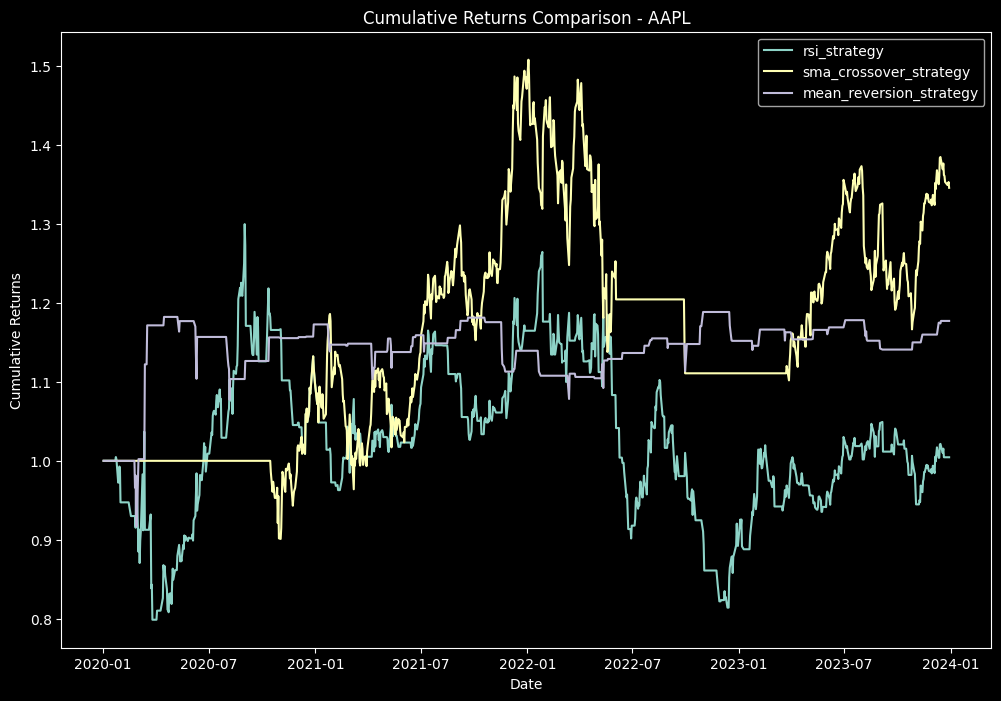

In [40]:
# ----------- Backtesting ----------- #

def backtest(strategy, ticker, start, end):
    data = strategy(ticker, start, end)
    data['Returns'] = data['Close'].pct_change()
    data['Strategy_Returns'] = data['Signal'].shift(1) * data['Returns']
    data['Cumulative_Strategy_Returns'] = (1 + data['Strategy_Returns'].fillna(0)).cumprod()
    data['Cumulative_Strategy_Returns'].plot(figsize=(10,6), title=f'Cumulative Returns - {strategy.__name__} - {ticker}')
    plt.show()

def multi_strategy_backtest(strategies, ticker, start, end):
    plt.figure(figsize=(12, 8))
    for strategy in strategies:
        data = strategy(ticker, start, end)
        data['Returns'] = data['Close'].pct_change()
        data['Strategy_Returns'] = data['Signal'].shift(1) * data['Returns']
        data['Cumulative_Strategy_Returns'] = (1 + data['Strategy_Returns'].fillna(0)).cumprod()
        plt.plot(data['Cumulative_Strategy_Returns'], label=f'{strategy.__name__}')
    plt.title(f'Cumulative Returns Comparison - {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()

#backtest(rsi_strategy, 'AAPL', '2020-01-01', '2024-01-01')
#backtest(sma_crossover_strategy, 'AAPL', '2020-01-01', '2024-01-01')
#backtest(mean_reversion_strategy, 'AAPL', '2020-01-01', '2024-01-01')

plt.style.use("dark_background")
strategies = [rsi_strategy, sma_crossover_strategy, mean_reversion_strategy]
multi_strategy_backtest(strategies, 'AAPL', '2020-01-01', '2024-01-01')

In [8]:
MAX_SHARES = 100
MAX_BUY_AMOUNT = 20000

In [9]:
# ----------- EXECUTION ----------- #

# Configurations
api = tradeapi.REST(API_KEY, API_SECRET, BASE_URL, api_version='v2')
logging.basicConfig(
    filename='trading-bot.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

def get_current_position(symbol):
    try:
        position = api.get_position(symbol)
        return int(position.qty), float(position.market_value)
    except tradeapi.rest.APIError:
        return 0, 0.0

# Place buy/sell order on Alpaca
def place_order(symbol, qty, side, type='market', time_in_force='gtc'):
    api.submit_order(
        symbol=symbol,
        qty=qty,
        side=side,
        time_in_force=time_in_force
    )
    logging.info(f'Order placed: {side.upper()} {qty} shares of {symbol}')

# Run trading bot
def run_trading_bot(ticker, strategy, quantity=1):
    logging.info(f'Running trading bot for {ticker} using {strategy.__name__} strategy')
    # Fetch historical data for the chosen ticker
    end = pd.Timestamp.today()
    start = end - pd.Timedelta(days=300)
    # Generate signals using the passed strategy function
    strategy_data = strategy(ticker, start, end)
    last_signal = strategy_data['Position'].iloc[-1]
    # Execute trade based on signal
    current_shares, current_value = get_current_position(ticker)
    if last_signal == 1:
        if (MAX_SHARES and current_shares + quantity > MAX_SHARES) or (MAX_BUY_AMOUNT and current_value + (quantity * strategy_data['Close'].iloc[-1]) > MAX_BUY_AMOUNT):
            logging.info(f"Max position reached for {ticker}. Buy order skipped.")
        else:
            place_order(symbol=ticker, qty=quantity, side='buy')
            logging.info(f"Placed BUY order for {ticker}")
    elif last_signal == -1:
        place_order(symbol=ticker, qty=quantity, side='sell')
        logging.info(f"Placed SELL order for {ticker}")
    else:
        logging.info(f"No trading signal for {ticker}")

In [11]:
# Schedule the bot to run every minute, passing the chosen strategy

schedule.every(1).minutes.do(run_trading_bot, ticker="AAPL", strategy=sma_crossover_strategy, quantity=1)
while True:
    schedule.run_pending()
    time.sleep(1)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


KeyboardInterrupt: 